# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
from gwpy.timeseries import TimeSeries
import copy
from scipy.interpolate import interp1d
from scipy.interpolate import splev, splrep
from scipy.special import logsumexp

In [3]:
theoretical_values = (68.6, 0.71)

## Data

Download data

In [4]:
home_dir = "./MDC_waveforms/"

In [5]:
H_filename = "H-H1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"
L_filename = "L-L1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"

In [6]:
H_data = TimeSeries.read(home_dir + H_filename, 'H1:NR_INJECTED')
L_data = TimeSeries.read(home_dir + L_filename, 'L1:NR_INJECTED')

In [68]:
white_noise0 = np.random.normal(0, 0.26*1e-22, len(H_data))
white_noise1 = np.random.normal(0, 1*1e-22, len(H_data))

In [63]:
peak_time = H_data.times.value[np.argmax(H_data)]
SSB_peak_time = peak_time - 0.014685396838313368

In [55]:
H_waveform = qnm_filter.Data(0*H_data.value+white_noise0, index = H_data.times.value)
L_waveform = qnm_filter.Data(L_data.value+white_noise1, index = L_data.times.value)

<AxesSubplot: >

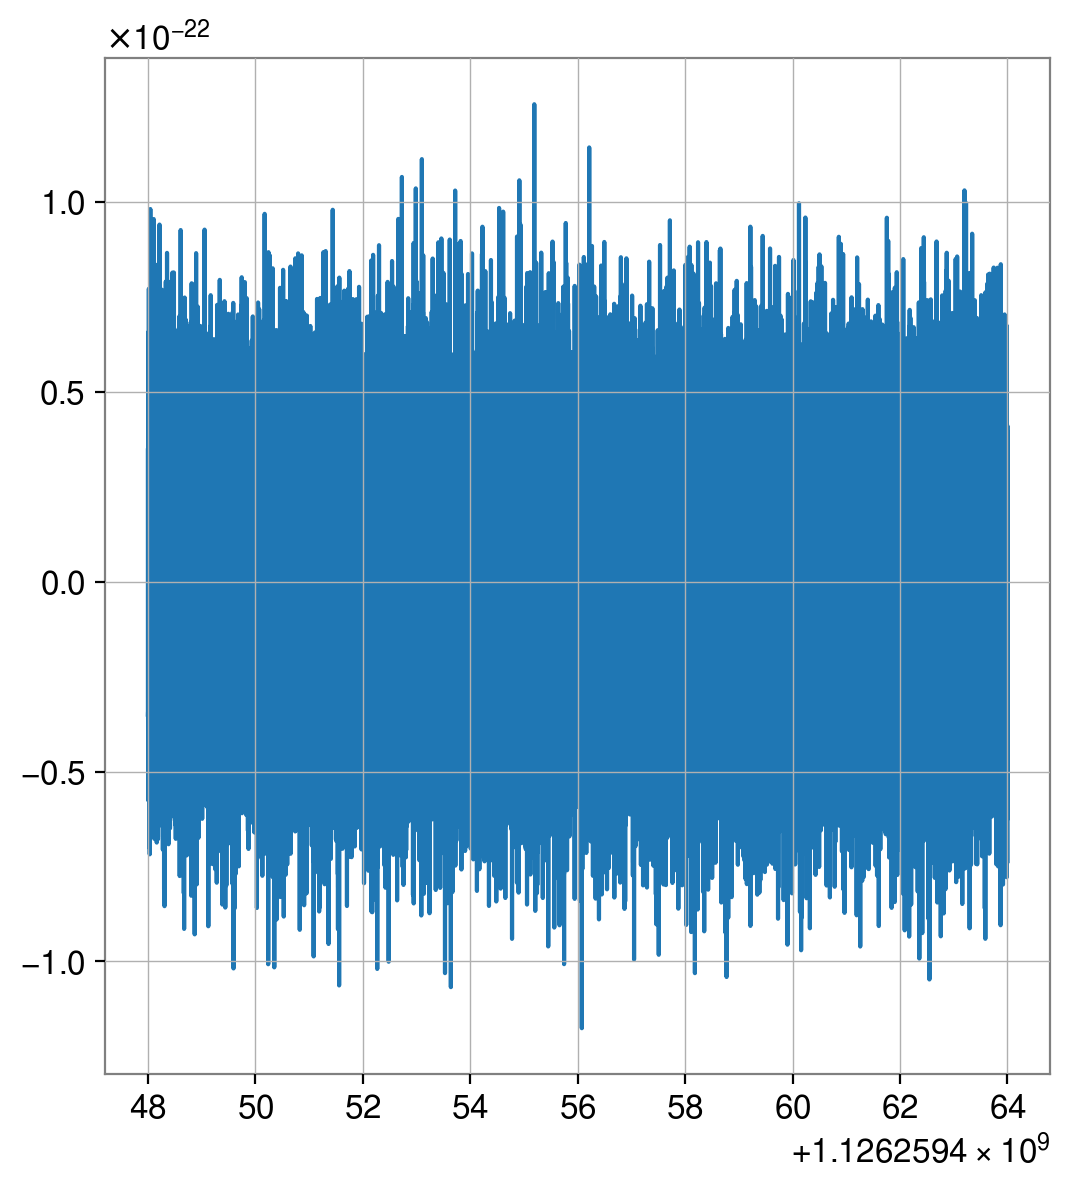

In [56]:
H_waveform.plot()

## Filter

In [11]:
mass_unit = qnm_filter.Filter.mass_unit(theoretical_values[0])

In [12]:
input = dict(model_list = [(2,2,0), (2,2,1),(2,2,2)], #l, m, n
             # trucation time (geocenter, in second)
             t_init = SSB_peak_time+0*mass_unit, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # sky localization
             ra = 1.95, dec = -1.27,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [13]:
fit.original_data['H1'] = H_waveform

In [14]:
fit.detector_alignment()
fit.condition_data('original_data', **input, trim = 0.0)
fit.pure_noise = {}
fit.pure_noise['H1'] = qnm_filter.Data(white_noise0, index = H_data.times.value)
fit.compute_acfs('pure_noise')
# temp_acf = np.full(input['srate'], 0, dtype = np.double)
# temp_acf[0] = 1e-22**2
# fit.acfs['H1'] = qnm_filter.Data(temp_acf, index = fit.acfs['H1'].index)

In [15]:
fit.cholesky_decomposition()

## SNR

In [16]:
fit_SNR = qnm_filter.Network(**input)
fit_SNR.original_data['H1'] = qnm_filter.Data(H_data.value, index = H_data.times.value)
fit_SNR.detector_alignment()
fit_SNR.condition_data('original_data', **input, trim = 0.0)
fit_SNR.compute_acfs('original_data')
fit_SNR.first_index()
fit.first_index()
template = fit_SNR.truncate_data(fit_SNR.original_data)['H1']

In [17]:
fit.compute_SNR(fit.truncate_data(fit.original_data)['H1'], template, 'H1', optimal=True)

66.63354077476933

In [18]:
delta_mass = 1.0
delta_chi = 0.05
massspace = np.arange(34, 140, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [19]:
fit.first_index()
likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)

In [20]:
credible_region = qnm_filter.find_credible_region(likelihood_data, target_probability=0.9)

In [21]:
projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, delta_mass, delta_chi)

In [22]:
filters_str = '+'.join([''.join(str(i) for i in j) for j in input['model_list']])
time_str = str(np.round((input['t_init'] - SSB_peak_time)/mass_unit, 2))

Text(105, 0.1, 'ln(evidence) = -364.81')

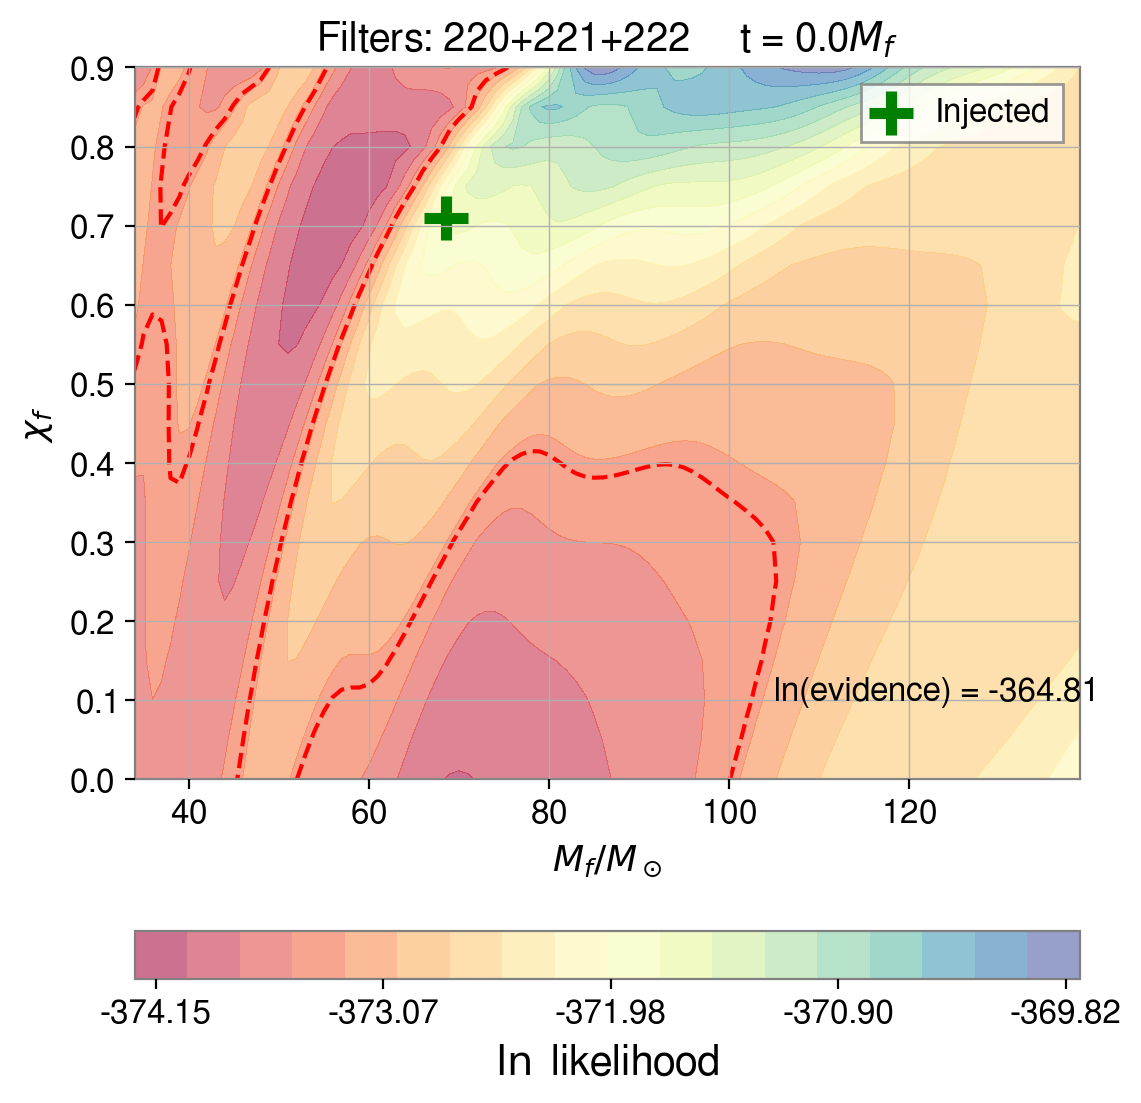

In [23]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=theoretical_values[0], y=theoretical_values[1], s=255, marker='+', 
           c='g', linewidths=4, label='Injected')
# ax.scatter(x=average_mass, y=average_chi, s=255, marker='+', 
#            c='r', linewidths=4, label='weighted average')
# ax.scatter(x=MAP_value[0], y=MAP_value[1], s=255, marker='+', 
#            c='y', linewidths=4, label='MAP')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.legend()
ax.set_title("Filters: " + filters_str + "     t = " + time_str + r'$M_f$')
ax.text(105, 0.1, 'ln(evidence) = %.2f' % logsumexp(likelihood_data))
# ax.text(118, 0.1, '$\epsilon_{MAP} = %.2f$' '\n' '$\epsilon_{avg} = %.2f$' % (MAP_epsilon, average_epsilon))

## Filters on pure noise

In [101]:
white_noise0 = np.random.normal(0, 0.26*1e-22, len(H_data))

In [107]:
H_waveform = qnm_filter.Data(0*H_data.value+white_noise0, index = H_data.times.value)
result_list = [(7,7,0) for _ in range(30)]
evidence_arr = []

for i in range(30):
    input['model_list'] = result_list[:i]
#     print(input['model_list'])
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = H_waveform
    fit.detector_alignment()
    fit.condition_data('original_data', **input, trim = 0.0)
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.Data(white_noise0, index = H_data.times.value)
    fit.condition_data('pure_noise')
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
    evidence_arr.append(evidence)

Text(0, 0.5, 'ln(evidence)')

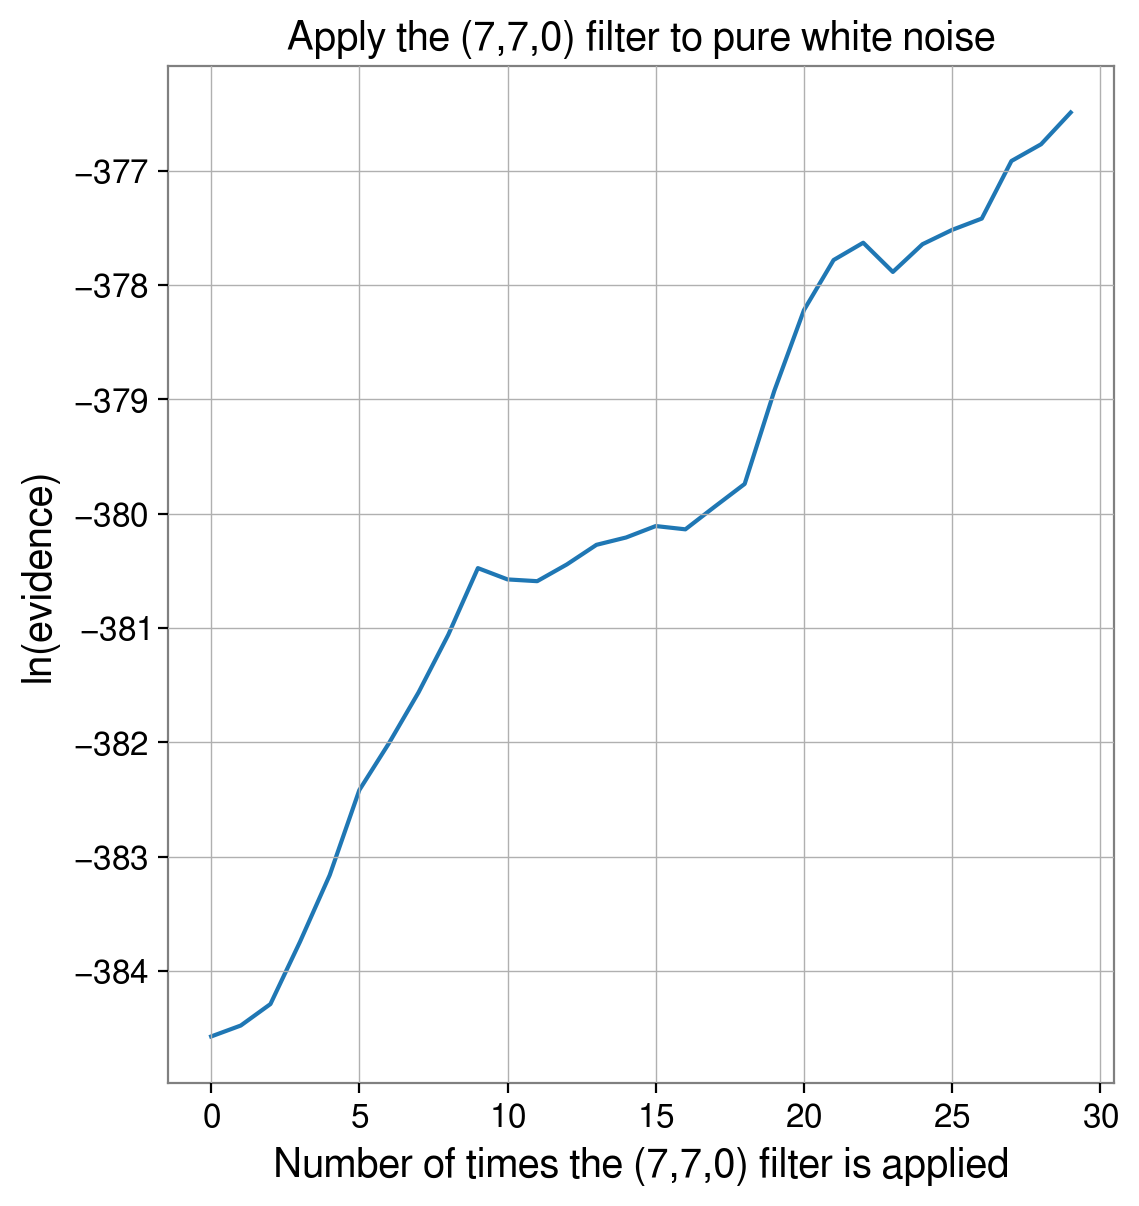

In [108]:
pl.plot(evidence_arr)
pl.title('Apply the (7,7,0) filter to pure white noise')
pl.xlabel('Number of times the (7,7,0) filter is applied')
pl.ylabel("ln(evidence)")

Text(100, 0.1, 'ln(evidence) = -376.49')

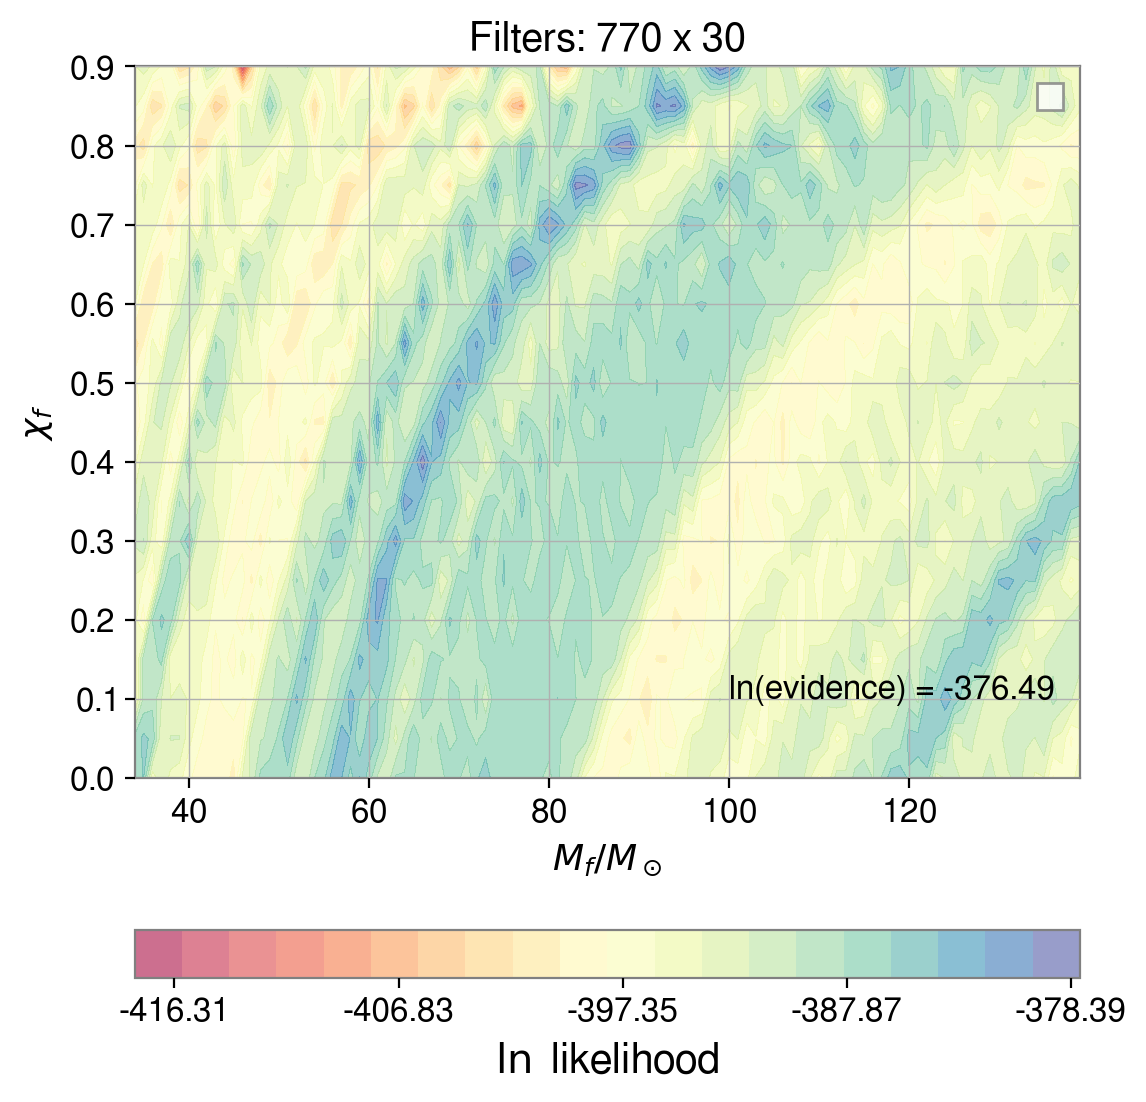

In [113]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
# dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
#                    linestyles ='--')
# ax.scatter(x=theoretical_values[0], y=theoretical_values[1], s=255, marker='+', 
#            c='g', linewidths=4, label='Injected')
# ax.scatter(x=average_mass, y=average_chi, s=255, marker='+', 
#            c='r', linewidths=4, label='weighted average')
# ax.scatter(x=MAP_value[0], y=MAP_value[1], s=255, marker='+', 
#            c='y', linewidths=4, label='MAP')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.legend()
ax.set_title("Filters: 770 x 30")
ax.text(100, 0.1, 'ln(evidence) = %.2f' % logsumexp(likelihood_data))
# ax.text(118, 0.1, '$\epsilon_{MAP} = %.2f$' '\n' '$\epsilon_{avg} = %.2f$' % (MAP_epsilon, average_epsilon))

## Is the slope constant?

In [123]:
white_noise0 = np.random.normal(0, 0.35*1e-22, len(H_data))

In [124]:
H_waveform = qnm_filter.Data(0*H_data.value+white_noise0, index = H_data.times.value)
result_list = [(7,7,0) for _ in range(30)]
evidence_arr = []

for i in range(10):
    input['model_list'] = result_list[:i]
    print(input['model_list'])
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = H_waveform
    fit.detector_alignment()
    fit.condition_data('original_data', **input, trim = 0.0)
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.Data(white_noise0, index = H_data.times.value)
    fit.condition_data('pure_noise')
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
    evidence_arr.append(evidence)

[]
[(7, 7, 0)]
[(7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]


In [127]:
H_waveform = qnm_filter.Data(0*H_data.value+0.8*white_noise0, index = H_data.times.value)
result_list = [(7,7,0) for _ in range(30)]
evidence_arr1 = []

for i in range(10):
    input['model_list'] = result_list[:i]
    print(input['model_list'])
    
    fit = qnm_filter.Network(**input)
    fit.original_data['H1'] = H_waveform
    fit.detector_alignment()
    fit.condition_data('original_data', **input, trim = 0.0)
    fit.pure_noise = {}
    fit.pure_noise['H1'] = qnm_filter.Data(white_noise0, index = H_data.times.value)
    fit.condition_data('pure_noise')
    fit.compute_acfs('pure_noise')
    fit.cholesky_decomposition()
    fit.first_index()
    likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
    evidence_arr1.append(evidence)

[]
[(7, 7, 0)]
[(7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]
[(7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0), (7, 7, 0)]


In [142]:
init = evidence_arr1[0] - evidence_arr[0]
final = evidence_arr1[-1] - evidence_arr[-1]
slope = (final - init)/10

In [152]:
slope

-0.2206223825910257

In [143]:
test = np.multiply(evidence_arr, slope)

In [144]:
test[-1] - test[0]

-0.8078767521740815

In [147]:
final

138.06901672271678

In [145]:
evidence_arr1[-1] - evidence_arr1[0]

1.4555839321523933

Text(0, 0.5, 'ln(evidence)')

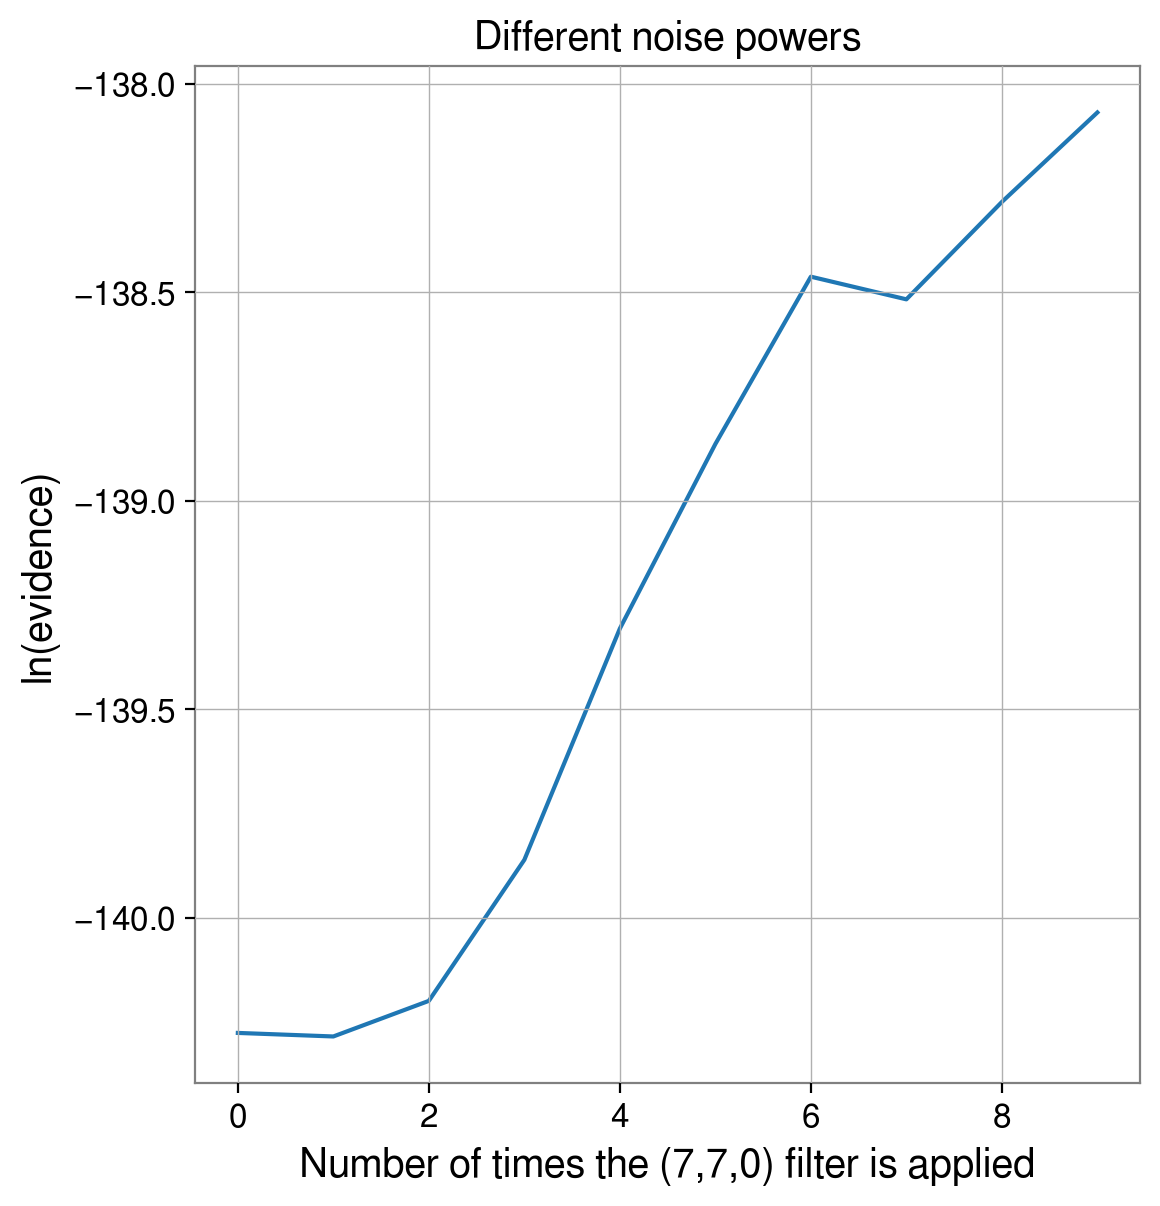

In [153]:
pl.plot(np.subtract(evidence_arr,evidence_arr1))
pl.title('Different noise powers')
pl.xlabel('Number of times the (7,7,0) filter is applied')
pl.ylabel("ln(evidence)")